In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from keras.metrics import mse
import matplotlib.pyplot as plt
from keras.backend import set_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, UpSampling2D, Input, Lambda, multiply, Input, concatenate
from keras.layers import LeakyReLU
from PIL import Image
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import random

def generate_bw_image(width, height, white_probability):
    image = Image.new("1", (width, height))
    pixels = image.load()
    for i in range(width):
        for j in range(height):
            if random.random() < white_probability:
                pixels[i, j] = 1
            else:
                pixels[i, j] = 0
    image.save("mask.png")



In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def ChangeImage(image, dim=32):
    x_cutting = image.size[0] - image.size[0] % dim
    y_cutting = image.size[1] - image.size[1] % dim

    a = (image.size[0] - x_cutting) // 2
    b = (image.size[1] - y_cutting) // 2
    c = (image.size[0] + x_cutting) // 2
    d = (image.size[1] + y_cutting) // 2

    cropped_image = img_to_array(image.crop([a,b,c,d]))
    cropped_image = (np.expand_dims(cropped_image, axis=0).astype('float32'))/255
    return cropped_image

In [ ]:
def add_noise(image, sigma):
    noise = np.clip(image + np.random.normal(scale=sigma, size=image.shape), 0, 1).astype(np.float32)
    return noise

In [ ]:

class Hourglass:
    def __init__(self, input_size, input_channel, output_channel, nu, nd, ns, ku, kd, ks, upsample_type='bilinear'):
        self.in_size = input_size
        self.in_channel = input_channel
        self.out_channel = output_channel
        self.nu = nu
        self.nd = nd
        self.ns = ns
        self.ku = ku
        self.kd = kd
        self.ks = ks
        self.upsample_type = upsample_type
        self.use_bias = True

    def up_sample(self, x, size=2):
        index = x.shape
        new_w = int(round(index[1] * size))
        new_h = int(round(index[2] * size))
        return tf.image.resize(x, [new_w, new_h], method=tf.image.ResizeMethod.BILINEAR)

    def down(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=2, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    
    def skip(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    def up(self, x, n, k, upsample_mode, use_bias=True):
        x = BatchNormalization()(x)
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(n, 1, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = self.up_sample(x, 2)
        return x
    
    def model_structure(self):
        width, height = self.in_size
        input = Input((width, height, self.in_channel))
        x = input
        n = 5
        skips = []
        x = self.down(x, self.nd[0], self.kd[0], self.use_bias)
        if self.ns[0] != 0:
            skip = self.skip(x, self.ns[0], self.ks[0], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[1], self.kd[1], self.use_bias)
        if self.ns[1] != 0:
            skip = self.skip(x, self.ns[1], self.ks[1], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[2], self.kd[2], self.use_bias)
        if self.ns[2] != 0:
            skip = self.skip(x, self.ns[2], self.ks[2], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[3], self.kd[3], self.use_bias)
        if self.ns[3] != 0:
            skip = self.skip(x, self.ns[3], self.ks[3], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[4], self.kd[4], self.use_bias)
        if self.ns[4] != 0:
            skip = self.skip(x, self.ns[4], self.ks[4], self.use_bias)
            skips.append(skip)

        x = self.up(x, self.nu[4], self.ku[4], self.upsample_type, self.use_bias)
        skips = skips[::-1]
        x = self.up(x, self.nu[3], self.ku[3],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[2]], axis=-1)
        x = self.up(x, self.nu[2], self.ku[2],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[3]], axis=-1)
        x = self.up(x, self.nu[1], self.ku[1],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[4]], axis=-1)
        x = self.up(x, self.nu[0], self.ku[0],self.upsample_type, self.use_bias)

        output = Conv2D(self.out_channel, 1, activation='sigmoid')(x)

        model = Model(inputs=input, outputs=output)
        return model

In [ ]:
def plot_losses(train_loss, image_title):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(image_title)
    # plt.figure(figsize=(10,10))
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.show()

In [ ]:
import os
import glob

folder_path = "./drive/MyDrive/SMAI_Project"  # replace with your folder path

file_list = []
for file_path in glob.glob(os.path.join(folder_path, "*")):
    file_list.append(file_path)
print(file_list)

['./drive/MyDrive/SMAI_Project/lenna.png', './drive/MyDrive/SMAI_Project/bridge.png', './drive/MyDrive/SMAI_Project/barbara.png', './drive/MyDrive/SMAI_Project/man.png', './drive/MyDrive/SMAI_Project/face.png', './drive/MyDrive/SMAI_Project/monarch.png', './drive/MyDrive/SMAI_Project/comic.png', './drive/MyDrive/SMAI_Project/baboon.png', './drive/MyDrive/SMAI_Project/pepper.png', './drive/MyDrive/SMAI_Project/foreman.png', './drive/MyDrive/SMAI_Project/coastguard.png', './drive/MyDrive/SMAI_Project/zebra.png', './drive/MyDrive/SMAI_Project/flowers.png', './drive/MyDrive/SMAI_Project/ppt3.png', './drive/MyDrive/SMAI_Project/lenna', './drive/MyDrive/SMAI_Project/bridge']


In [ ]:
def model_obj(x):
  b, w, h, c = x.shape

  ### build model
  layers = Hourglass((w, h), input_channel, c,
                        nu=[128, 128, 128, 128, 128],
                        nd=[128, 128, 128, 128, 128],
                        ns=[4, 4, 4, 4, 128],
                        ku=[3, 3, 3, 3, 3],
                        kd=[3, 3, 3, 3, 3],
                        ks=[1, 1, 1, 1, 1],
                        upsample_type='bilinear'
                        )
  
  return layers

[Errno 17] File exists: './drive/MyDrive/SMAI_Project/lenna'

---------------------------lenna---------------------------


iteration no.: 0 ,loss : 0.027095
iteration no.: 500 ,loss : 0.000588
iteration no.: 1000 ,loss : 0.000367
iteration no.: 1500 ,loss : 0.000276
iteration no.: 2000 ,loss : 0.000246
iteration no.: 2500 ,loss : 0.000210
iteration no.: 3000 ,loss : 0.000190
iteration no.: 3500 ,loss : 0.000178
iteration no.: 4000 ,loss : 0.000163
iteration no.: 4500 ,loss : 0.000148
iteration no.: 5000 ,loss : 0.000147
iteration no.: 5500 ,loss : 0.000144
iteration no.: 6000 ,loss : 0.000132
iteration no.: 6500 ,loss : 0.000131
iteration no.: 7000 ,loss : 0.000127
iteration no.: 7500 ,loss : 0.000121
iteration no.: 8000 ,loss : 0.000113


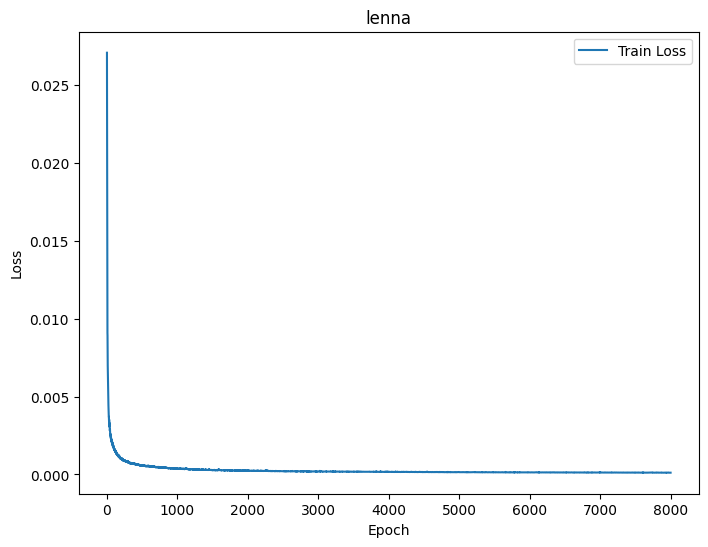

[Errno 17] File exists: './drive/MyDrive/SMAI_Project/bridge'

---------------------------bridge---------------------------


iteration no.: 0 ,loss : 0.020361
iteration no.: 500 ,loss : 0.001759
iteration no.: 1000 ,loss : 0.001172
iteration no.: 1500 ,loss : 0.000934
iteration no.: 2000 ,loss : 0.000796
iteration no.: 2500 ,loss : 0.000675
iteration no.: 3000 ,loss : 0.000621
iteration no.: 3500 ,loss : 0.000548
iteration no.: 4000 ,loss : 0.000497
iteration no.: 4500 ,loss : 0.000489
iteration no.: 5000 ,loss : 0.000440
iteration no.: 5500 ,loss : 0.000392
iteration no.: 6000 ,loss : 0.000379
iteration no.: 6500 ,loss : 0.000345
iteration no.: 7000 ,loss : 0.000344
iteration no.: 7500 ,loss : 0.000318
iteration no.: 8000 ,loss : 0.000331


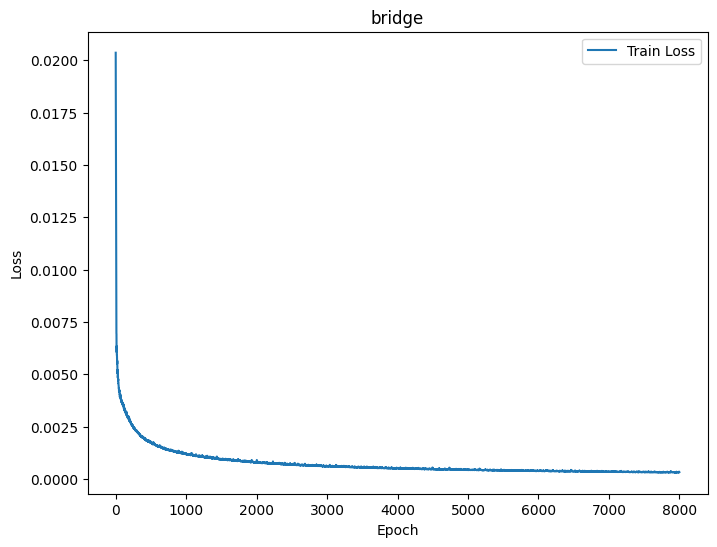


---------------------------barbara---------------------------


iteration no.: 0 ,loss : 0.020314
iteration no.: 500 ,loss : 0.001467
iteration no.: 1000 ,loss : 0.000996
iteration no.: 1500 ,loss : 0.000837
iteration no.: 2000 ,loss : 0.000751
iteration no.: 2500 ,loss : 0.000673
iteration no.: 3000 ,loss : 0.000612
iteration no.: 3500 ,loss : 0.000560
iteration no.: 4000 ,loss : 0.000516
iteration no.: 4500 ,loss : 0.000482
iteration no.: 5000 ,loss : 0.000453
iteration no.: 5500 ,loss : 0.000436
iteration no.: 6000 ,loss : 0.000402
iteration no.: 6500 ,loss : 0.000390
iteration no.: 7000 ,loss : 0.000375
iteration no.: 7500 ,loss : 0.000378
iteration no.: 8000 ,loss : 0.000348


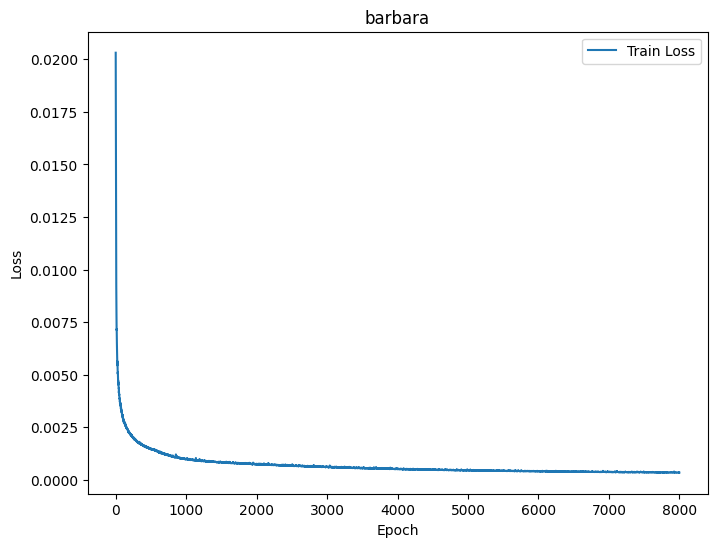


---------------------------man---------------------------


iteration no.: 0 ,loss : 0.028892
iteration no.: 500 ,loss : 0.001208
iteration no.: 1000 ,loss : 0.000765
iteration no.: 1500 ,loss : 0.000607
iteration no.: 2000 ,loss : 0.000525
iteration no.: 2500 ,loss : 0.000448
iteration no.: 3000 ,loss : 0.000391
iteration no.: 3500 ,loss : 0.000358
iteration no.: 4000 ,loss : 0.000343
iteration no.: 4500 ,loss : 0.000299
iteration no.: 5000 ,loss : 0.000265
iteration no.: 5500 ,loss : 0.000259
iteration no.: 6000 ,loss : 0.000265
iteration no.: 6500 ,loss : 0.000254
iteration no.: 7000 ,loss : 0.000226
iteration no.: 7500 ,loss : 0.000206
iteration no.: 8000 ,loss : 0.000208


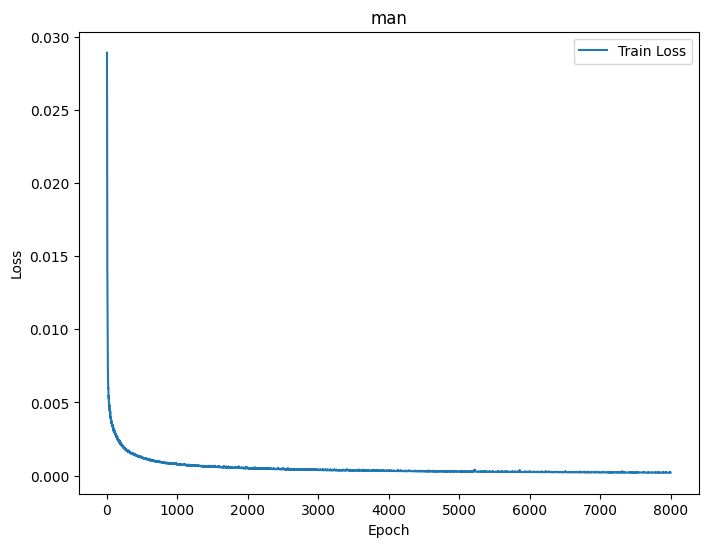


---------------------------face---------------------------


iteration no.: 0 ,loss : 0.049697
iteration no.: 500 ,loss : 0.000492
iteration no.: 1000 ,loss : 0.000338
iteration no.: 1500 ,loss : 0.000282
iteration no.: 2000 ,loss : 0.000248
iteration no.: 2500 ,loss : 0.000214
iteration no.: 3000 ,loss : 0.000197
iteration no.: 3500 ,loss : 0.000184
iteration no.: 4000 ,loss : 0.000172
iteration no.: 4500 ,loss : 0.000161
iteration no.: 5000 ,loss : 0.000160
iteration no.: 5500 ,loss : 0.000147
iteration no.: 6000 ,loss : 0.000142
iteration no.: 6500 ,loss : 0.000138
iteration no.: 7000 ,loss : 0.000128
iteration no.: 7500 ,loss : 0.000124
iteration no.: 8000 ,loss : 0.000119


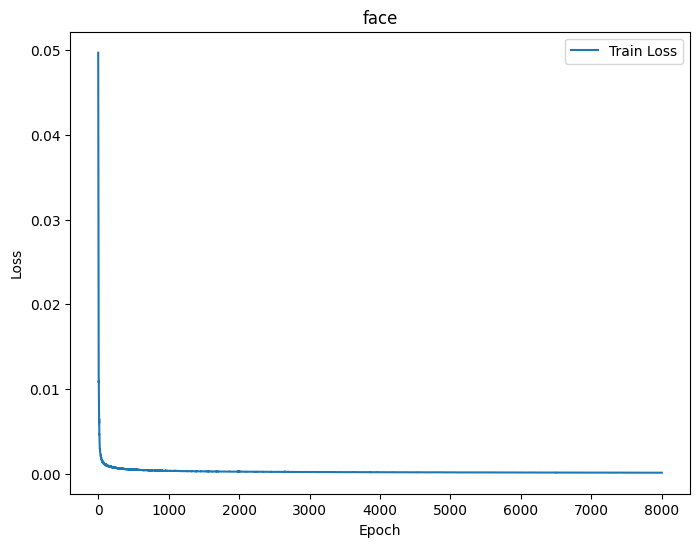


---------------------------monarch---------------------------


iteration no.: 0 ,loss : 0.024899
iteration no.: 500 ,loss : 0.000935
iteration no.: 1000 ,loss : 0.000461
iteration no.: 1500 ,loss : 0.000296
iteration no.: 2000 ,loss : 0.000228
iteration no.: 2500 ,loss : 0.000225
iteration no.: 3000 ,loss : 0.000170
iteration no.: 3500 ,loss : 0.000144
iteration no.: 4000 ,loss : 0.000133
iteration no.: 4500 ,loss : 0.000113
iteration no.: 5000 ,loss : 0.000105
iteration no.: 5500 ,loss : 0.000098
iteration no.: 6000 ,loss : 0.000095
iteration no.: 6500 ,loss : 0.000089
iteration no.: 7000 ,loss : 0.000086
iteration no.: 7500 ,loss : 0.000077
iteration no.: 8000 ,loss : 0.000072


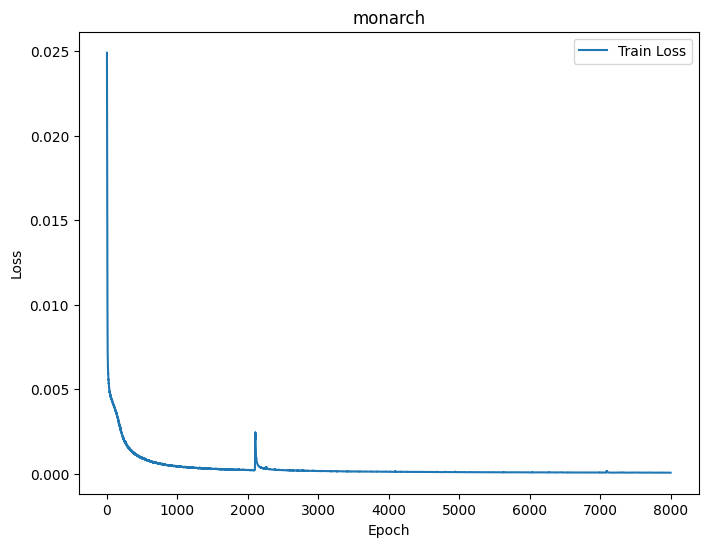


---------------------------comic---------------------------


iteration no.: 0 ,loss : 0.023019
iteration no.: 500 ,loss : 0.002191
iteration no.: 1000 ,loss : 0.001407
iteration no.: 1500 ,loss : 0.001050
iteration no.: 2000 ,loss : 0.000855
iteration no.: 2500 ,loss : 0.000710
iteration no.: 3000 ,loss : 0.000626
iteration no.: 3500 ,loss : 0.000574
iteration no.: 4000 ,loss : 0.000508
iteration no.: 4500 ,loss : 0.000468
iteration no.: 5000 ,loss : 0.000436
iteration no.: 5500 ,loss : 0.000392
iteration no.: 6000 ,loss : 0.000369
iteration no.: 6500 ,loss : 0.000352
iteration no.: 7000 ,loss : 0.000323
iteration no.: 7500 ,loss : 0.000310
iteration no.: 8000 ,loss : 0.000299


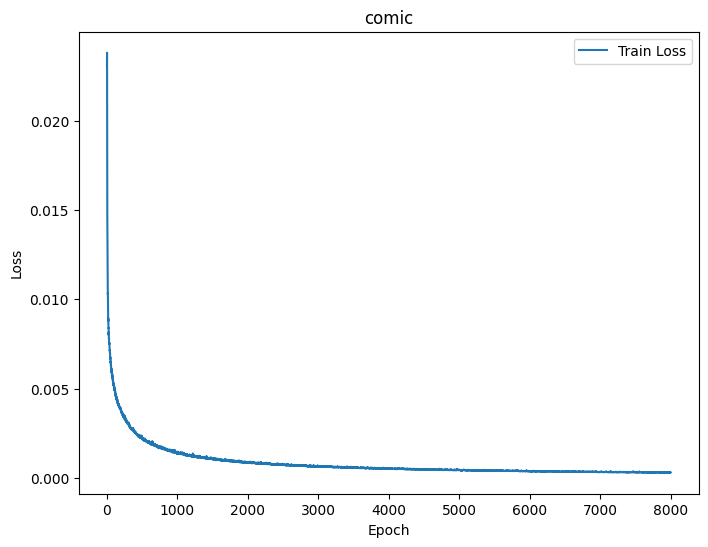


---------------------------baboon---------------------------


iteration no.: 0 ,loss : 0.031400
iteration no.: 500 ,loss : 0.002928
iteration no.: 1000 ,loss : 0.002265
iteration no.: 1500 ,loss : 0.001914
iteration no.: 2000 ,loss : 0.001697
iteration no.: 2500 ,loss : 0.001529
iteration no.: 3000 ,loss : 0.001385
iteration no.: 3500 ,loss : 0.001283
iteration no.: 4000 ,loss : 0.001211
iteration no.: 4500 ,loss : 0.001133
iteration no.: 5000 ,loss : 0.001064
iteration no.: 5500 ,loss : 0.001016
iteration no.: 6000 ,loss : 0.000956
iteration no.: 6500 ,loss : 0.000931
iteration no.: 7000 ,loss : 0.000874
iteration no.: 7500 ,loss : 0.000850
iteration no.: 8000 ,loss : 0.000821


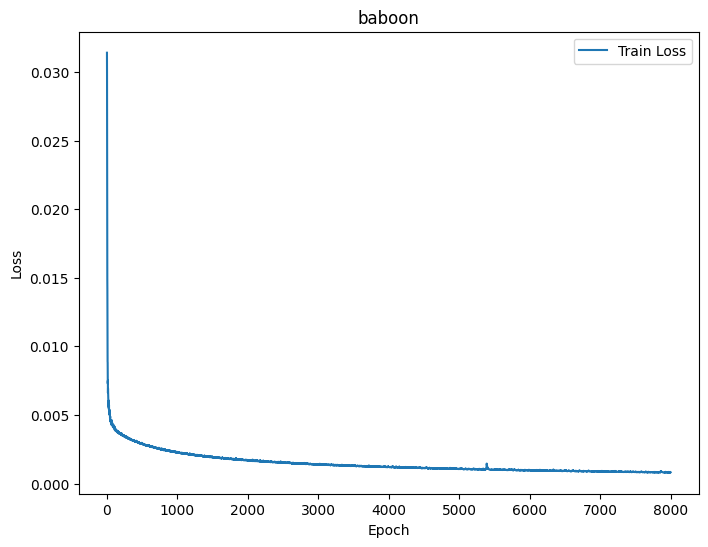


---------------------------pepper---------------------------


iteration no.: 0 ,loss : 0.021923
iteration no.: 500 ,loss : 0.000683
iteration no.: 1000 ,loss : 0.000389
iteration no.: 1500 ,loss : 0.000308
iteration no.: 2000 ,loss : 0.000271
iteration no.: 2500 ,loss : 0.000239
iteration no.: 3000 ,loss : 0.000213
iteration no.: 3500 ,loss : 0.000201
iteration no.: 4000 ,loss : 0.000192
iteration no.: 4500 ,loss : 0.000184
iteration no.: 5000 ,loss : 0.000173
iteration no.: 5500 ,loss : 0.000166
iteration no.: 6000 ,loss : 0.000162
iteration no.: 6500 ,loss : 0.000154
iteration no.: 7000 ,loss : 0.000159
iteration no.: 7500 ,loss : 0.000143
iteration no.: 8000 ,loss : 0.000140


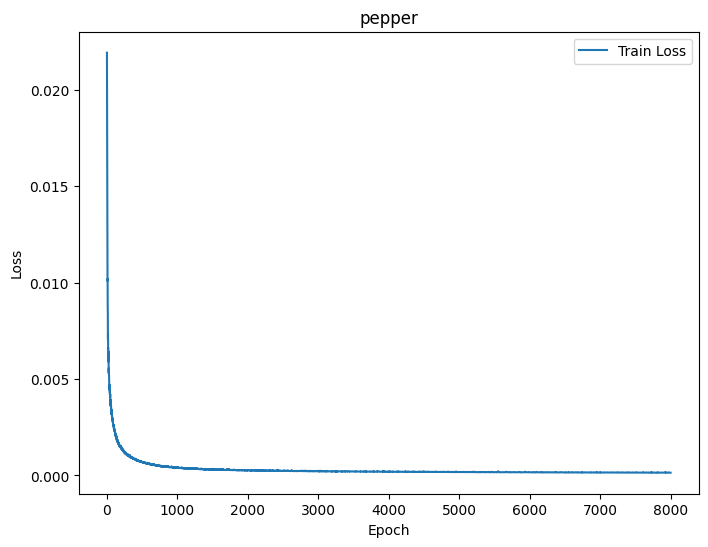


---------------------------foreman---------------------------


iteration no.: 0 ,loss : 0.037647
iteration no.: 500 ,loss : 0.000500
iteration no.: 1000 ,loss : 0.000283
iteration no.: 1500 ,loss : 0.000217
iteration no.: 2000 ,loss : 0.000183
iteration no.: 2500 ,loss : 0.000159
iteration no.: 3000 ,loss : 0.000149
iteration no.: 3500 ,loss : 0.000127
iteration no.: 4000 ,loss : 0.000123
iteration no.: 4500 ,loss : 0.000114
iteration no.: 5000 ,loss : 0.000099
iteration no.: 5500 ,loss : 0.000094
iteration no.: 6000 ,loss : 0.000322
iteration no.: 6500 ,loss : 0.000137
iteration no.: 7000 ,loss : 0.000111
iteration no.: 7500 ,loss : 0.000099
iteration no.: 8000 ,loss : 0.000092


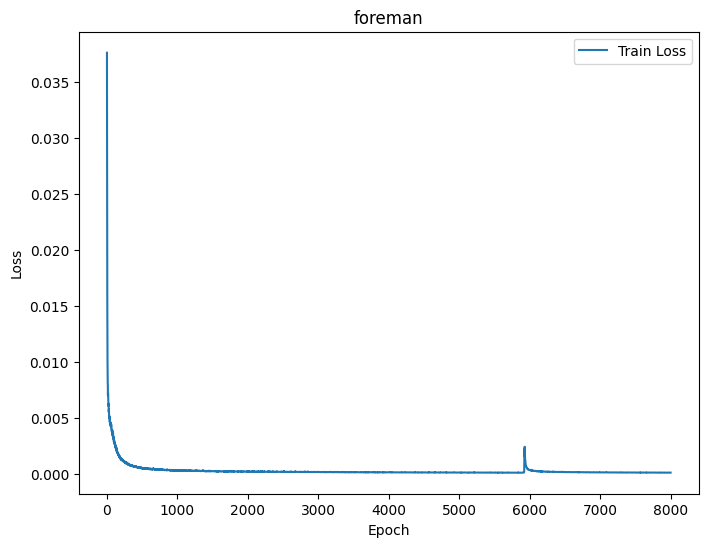


---------------------------coastguard---------------------------


iteration no.: 0 ,loss : 0.019604
iteration no.: 500 ,loss : 0.000985
iteration no.: 1000 ,loss : 0.000679
iteration no.: 1500 ,loss : 0.000547
iteration no.: 2000 ,loss : 0.000466
iteration no.: 2500 ,loss : 0.000393
iteration no.: 3000 ,loss : 0.000371
iteration no.: 3500 ,loss : 0.000308
iteration no.: 4000 ,loss : 0.000302
iteration no.: 4500 ,loss : 0.000264
iteration no.: 5000 ,loss : 0.000236
iteration no.: 5500 ,loss : 0.000220
iteration no.: 6000 ,loss : 0.000209
iteration no.: 6500 ,loss : 0.000191
iteration no.: 7000 ,loss : 0.000174
iteration no.: 7500 ,loss : 0.000165
iteration no.: 8000 ,loss : 0.000161


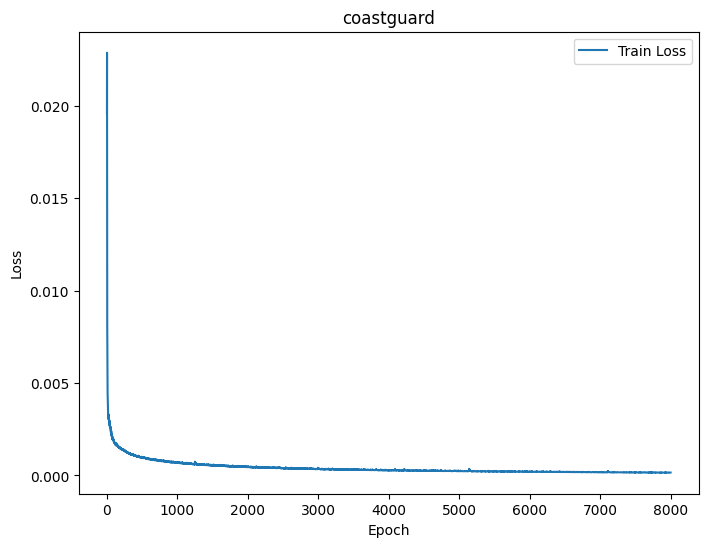


---------------------------zebra---------------------------


iteration no.: 0 ,loss : 0.022724
iteration no.: 500 ,loss : 0.001391
iteration no.: 1000 ,loss : 0.000838
iteration no.: 1500 ,loss : 0.000608
iteration no.: 2000 ,loss : 0.000497
iteration no.: 2500 ,loss : 0.000419
iteration no.: 3000 ,loss : 0.000336
iteration no.: 3500 ,loss : 0.000301
iteration no.: 4000 ,loss : 0.000258
iteration no.: 4500 ,loss : 0.000245
iteration no.: 5000 ,loss : 0.000234
iteration no.: 5500 ,loss : 0.000213
iteration no.: 6000 ,loss : 0.000187
iteration no.: 6500 ,loss : 0.000170
iteration no.: 7000 ,loss : 0.000168
iteration no.: 7500 ,loss : 0.000157
iteration no.: 8000 ,loss : 0.000152


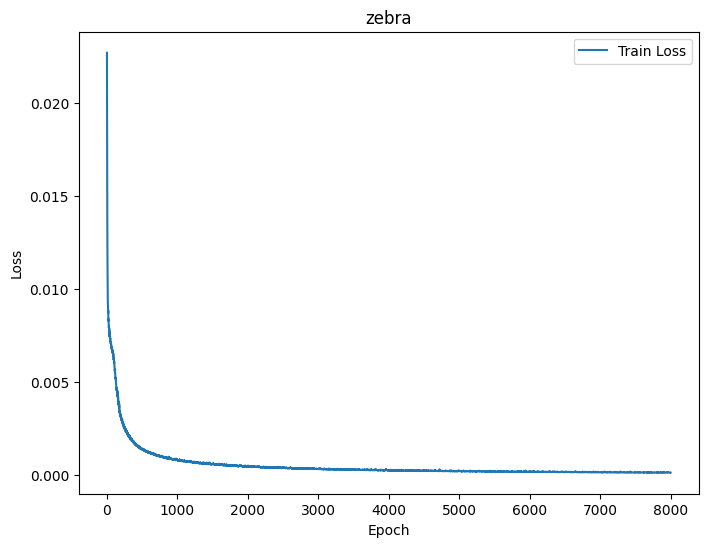


---------------------------flowers---------------------------


iteration no.: 0 ,loss : 0.028949
iteration no.: 500 ,loss : 0.001509
iteration no.: 1000 ,loss : 0.000915
iteration no.: 1500 ,loss : 0.000701
iteration no.: 2000 ,loss : 0.000567
iteration no.: 2500 ,loss : 0.000486
iteration no.: 3000 ,loss : 0.000424
iteration no.: 3500 ,loss : 0.000373
iteration no.: 4000 ,loss : 0.000325
iteration no.: 4500 ,loss : 0.000302
iteration no.: 5000 ,loss : 0.000271
iteration no.: 5500 ,loss : 0.000248
iteration no.: 6000 ,loss : 0.000236
iteration no.: 6500 ,loss : 0.000220
iteration no.: 7000 ,loss : 0.000200
iteration no.: 7500 ,loss : 0.000202
iteration no.: 8000 ,loss : 0.000184


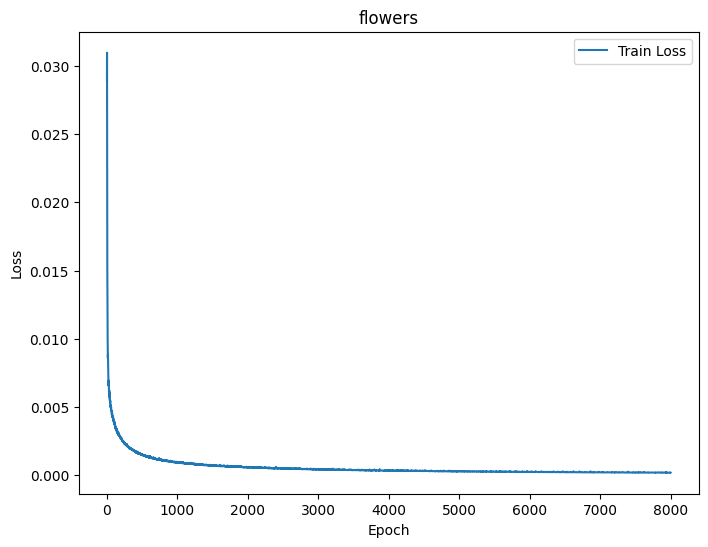


---------------------------ppt3---------------------------


iteration no.: 0 ,loss : 0.052817
iteration no.: 500 ,loss : 0.002129
iteration no.: 1000 ,loss : 0.001079
iteration no.: 1500 ,loss : 0.000702
iteration no.: 2000 ,loss : 0.000525
iteration no.: 2500 ,loss : 0.000394
iteration no.: 3000 ,loss : 0.000320
iteration no.: 3500 ,loss : 0.000299
iteration no.: 4000 ,loss : 0.000256
iteration no.: 4500 ,loss : 0.000218
iteration no.: 5000 ,loss : 0.000193
iteration no.: 5500 ,loss : 0.000185
iteration no.: 6000 ,loss : 0.000163
iteration no.: 6500 ,loss : 0.000150
iteration no.: 7000 ,loss : 0.000156
iteration no.: 7500 ,loss : 0.000129
iteration no.: 8000 ,loss : 0.000122


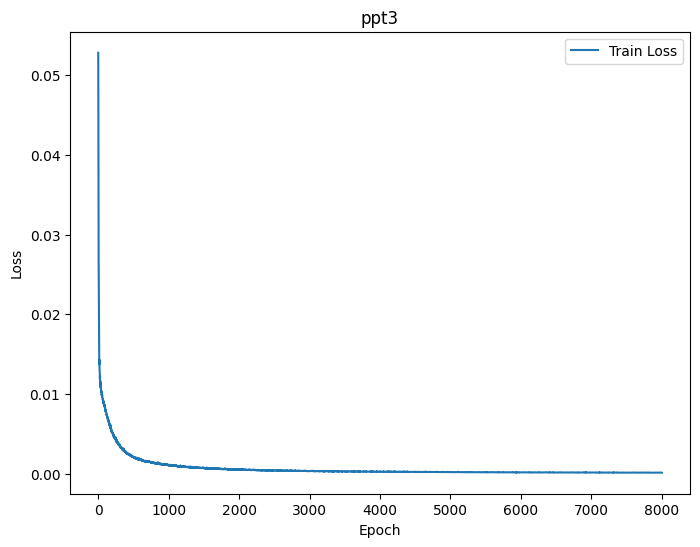

IsADirectoryError: ignored

In [ ]:
image_mask = "mask.png"

for image in file_list:
  # image_path = 'zebra.png'
  ## experiment options

  
  sigma = 1. / 30
  method = 'random'
  input_channel = 3
  num_iter = 8000
  lr = 0.01

  ### load data
  img = load_img(image)
  w,h = img.size 
  x = ChangeImage(img)
  generate_bw_image(w,h,0.25)
  
  mask = load_img(image_mask)
  mask = ChangeImage(mask)
  # x = add_noise(x,25 / 255.)
  words = image.split('/')
  imm = words[-1].split('.')[0]
  full_path = './drive/MyDrive/SMAI_Project/{}'.format(imm)
  try:
    os.mkdir(full_path) 
  except OSError as error: 
    print(error)  
  # os.mkdir(imm)
  print("\n---------------------------{}---------------------------".format(imm))
  original = x * mask
  array_to_img(original[0]).save('{}/noise.png'.format(full_path))
  # array_to_img(original[0]).save('{}/noise.png'.format(full_path))
  layers = model_obj(original)
  b, w, h, c = original.shape
  mod = layers.model_structure()
  #----------------------------------------------------------
  input = mod.input
  mask_input = Input((w, h, c))
  y = mod.output
  output = multiply([y, mask_input])
  model = Model(inputs=[input, mask_input], outputs=output,name='trainer')
#----------------------------------------------------------
  model.compile(optimizer=Adam(lr=lr), loss=mse)
  # model.summary()

  train_loss = []
  z = np.random.uniform(0, 0.1, size=(1,w,h,input_channel))
  losses = []
  for i in range(num_iter+1):
      with tf.device('/GPU:0'):
        temp = z + np.random.normal(0, sigma, size = z.shape)
        loss = model.train_on_batch([temp, mask], original)
        train_loss.append(loss)
        if i % 500 == 0:
            print('iteration no.: %d ,loss : %f' % (i, loss))
            y = mod.predict_on_batch(z)
            array_to_img(y[0]).save('{}/{}.png'.format(full_path, i))

  plot_losses(train_loss, imm)